Code from: https://www.kaggle.com/code/sid321axn/step-wise-approach-cnn-model-77-0344-accuracy

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
# from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

np.random.seed(42069) 

2023-03-29 15:02:20.601315: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-29 15:02:21.762878: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/vande/miniconda3/envs/tf/lib/
2023-03-29 15:02:21.765161: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/vande/miniconda3/envs/tf/lib/
2023-03-29 15:02:21.765224: W tensorflow/compiler/tf2ten

In [2]:
def plot_model_history(model_history):
    epoch_start = 3
    epoch_end = len(model_history.history['loss'])
    epochs = range(epoch_start+1,epoch_end+1)
    loss = model_history.history['loss'][epoch_start:]
    val_loss = model_history.history['val_loss'][epoch_start:]

    acc = model_history.history['accuracy'][epoch_start:]
    val_acc = model_history.history['val_accuracy'][epoch_start:]

    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(epochs,acc)
    axs[0].plot(epochs,val_acc)
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(epochs,loss)
    axs[1].plot(epochs,val_loss)
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [3]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [4]:
skin_df = pd.read_csv('metadata.csv')

skin_df['path'] = skin_df['image_id'].map(lambda id: os.path.join("images", id + ".jpg"))
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [5]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [6]:
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

In [7]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

In [8]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [9]:
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [10]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [11]:
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [12]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input

from keras.models import Model
from keras import Input
from keras.layers import GlobalAveragePooling2D

input_shape = (75, 100, 3)
num_classes = 7

densenet = DenseNet201(include_top=False, input_shape=input_shape)

model = Sequential()
model.add(densenet)
model.add(Flatten())
model.add(Dense(num_classes, activation="softmax"))
model.summary()

2023-03-29 15:03:38.939835: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-29 15:03:38.970045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-29 15:03:38.970107: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-29 15:03:38.971191: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 2, 3, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 7)                 80647     
                                                                 
Total params: 18,402,631
Trainable params: 18,173,575
Non-trainable params: 229,056
_________________________________________________________________


In [13]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

/home/vande/miniconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [15]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [16]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [17]:
epochs = 20
batch_size = 64
history = model.fit_generator(datagen.flow(x_train,y_train,batch_size=batch_size),
                              epochs = epochs, 
                              validation_data = (x_validate,y_validate),
                              verbose = 1,
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

Epoch 1/20


/tmp/ipykernel_3467/2669422811.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train,y_train,batch_size=batch_size),
2023-03-29 15:03:58.921616: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-29 15:03:59.948071: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-03-29 15:03:59.948119: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:237] Used ptxas at ptxas
2023-03-29 15:03:59.948223: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-03-29 15:04:01.759

112/112 [==============================] - 34s 158ms/step - loss: 1.0042 - accuracy: 0.6854 - val_loss: 7703.6157 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 2/20
112/112 [==============================] - 12s 104ms/step - loss: 0.9608 - accuracy: 0.6968 - val_loss: 20.0961 - val_accuracy: 0.5299 - lr: 0.0010
Epoch 3/20
112/112 [==============================] - 11s 100ms/step - loss: 1.0396 - accuracy: 0.6965 - val_loss: 10684.6025 - val_accuracy: 0.6870 - lr: 0.0010
Epoch 4/20
112/112 [==============================] - 12s 103ms/step - loss: 0.8710 - accuracy: 0.7075 - val_loss: 24.4370 - val_accuracy: 0.7070 - lr: 0.0010
Epoch 5/20
112/112 [==============================] - 12s 107ms/step - loss: 0.7419 - accuracy: 0.7239 - val_loss: 0.7126 - val_accuracy: 0.7481 - lr: 0.0010
Epoch 6/20
112/112 [==============================] - 12s 106ms/step - loss: 0.7102 - accuracy: 0.7424 - val_loss: 0.6841 - val_accuracy: 0.7469 - lr: 0.0010
Epoch 7/20
112/112 [==============================] - 

In [18]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

26/26 [==============================] - 1s 27ms/step - loss: 0.6253 - accuracy: 0.7631
Validation: accuracy = 0.763092  ;  loss_v = 0.625344
Test: accuracy = 0.754368  ;  loss = 0.640130


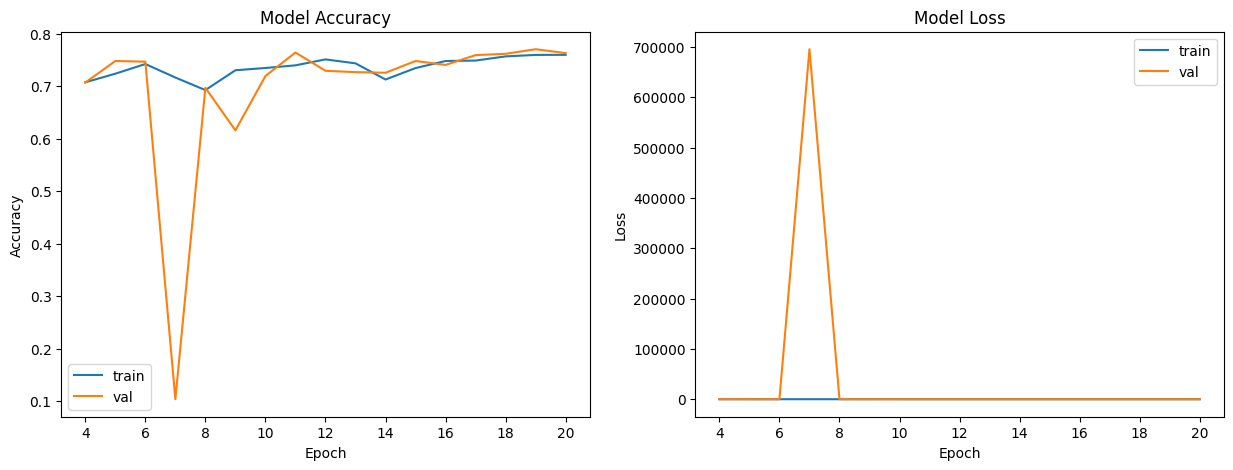

In [19]:
plot_model_history(history)

In [20]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [67]:
from sklearn.metrics import confusion_matrix

a = pd.array(Y_true).unique()
b = [x[0] for x in skin_df["dx"].value_counts().items()]

labels = [x[1] for x in sorted(zip(a,b), key=lambda a: a[0])]


Y_pred = model.predict(x_test)
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(y_test, axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = labels) 

loss_t, accuracy_t = model.evaluate(x_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy_t, loss_t))

63/63 [==============================] - 2s 27ms/step


ValueError: Found input variables with inconsistent numbers of samples: [2003, 7]

['vasc', 'akiec', 'mel', 'df', 'nv', 'bcc', 'bkl']

<Axes: >

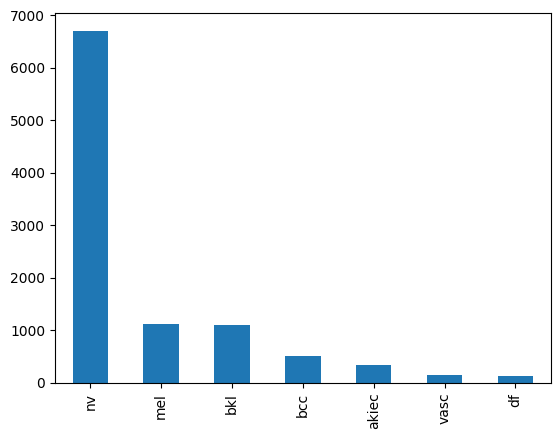

In [22]:
skin_df["dx"].value_counts().plot(kind="bar")